# Introduction to Lightkurve

Lightkurve is an open source python tool for investigating Kepler, K2, and TESS data.  The available functionality includes:

1. Searching for Kepler, K2 and TESS data at MAST.stsci.edu
2. Downloading target pixel files and lightcurve files from MAST.stsci.edu
3. Investigating and definining custom apertures
4. Creating a bespoke lightcurve
5. Correcting lightcurves
6. Removing systematics from lightcurves
7. Exporting your lightcurves to other formats

And lots more...  I'll cover these topics in the next 15 minutes (at warp speed).  Oliver Hall will present how to do astereoseismology with lightkurve.

You can learn more and find loads more tutorials at https://keplerscience.arc.nasa.gov/software.html and https://docs.lightkurve.org/


In [ ]:
! pip install lightkurve #if running in google colab

In [1]:
import lightkurve as lk

## 1. Searching for data

Lightkurve provides several search functions which allow you to query MAST.stsci.edu for target pixel files, lightcurves and TESS cut-outs.  Targets can be specified by KIC id, EPIC id, TIC id, target name, or RA/Dec.

EPIC 205901703 is a 8.2 KepMag red giant star observed by both TESS and K2.

Target pixel files are a time series of images containing a cut out of pixels around the target.  Let's start by seeing what target pixel files are avaialble...

In [2]:
mytarget = "EPIC 205901703"

tpf_list = lk.search_targetpixelfile(mytarget)

tpf_list

SearchResult containing 2 data products.

 target_name                      productFilename                                  description              distance
------------- ------------------------------------------------------- ------------------------------------- --------
ktwo205901703                      ktwo205901703-c03_lpd-targ.fits.gz Target Pixel Long Cadence (KTL) - C03      0.0
     69763457 tess2018234235059-s0002-0000000069763457-0121-s_tp.fits                    Target pixel files      0.0

Great!  It's got K2 long cadence and TESS 2-minute cadence target pixel files.  But let's go ahead and look for 30 minute data via the TESS cut service.

In [3]:
tesscut_list = lk.search_tesscut(mytarget)
tesscut_list

SearchResult containing 1 data products.

 target_name   productFilename        description         distance
-------------- --------------- -------------------------- --------
EPIC 205901703             n/a TESS FFI Cutout (sector 2)      0.0

And finally -- let's look to see what lightcurves are available...

In [4]:
lc_list = lk.search_lightcurvefile(mytarget)

lc_list

SearchResult containing 2 data products.

 target_name                      productFilename                                 description             distance
------------- ------------------------------------------------------- ----------------------------------- --------
ktwo205901703                              ktwo205901703-c03_llc.fits Lightcurve Long Cadence (KLC) - C03      0.0
     69763457 tess2018234235059-s0002-0000000069763457-0121-s_lc.fits                        Light curves      0.0

## 2. Downloading data

Now that we know what data's available, let's download a target pixel file and load it into lightkurve. Downloading is a method that applies to lightkurve search results.  

In [5]:
k2_tpf = tpf_list[0].download()

It's also possible to string together the searching and downloading steps into a single command.  The command below yields identical results!

k2_tpf = lk.search_targetpixelfile(mytarget, mission="K2").download()

Before moving on, let's investigate this target pixel file object a bit...

What does it look like?

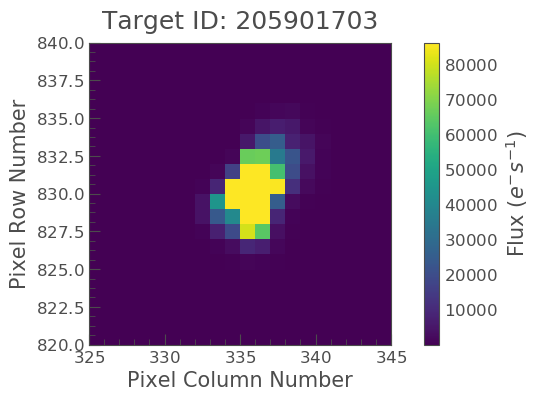

In [6]:
k2_tpf.plot()

How big are the images?

In [7]:
k2_tpf.flux.shape

(3192, 20, 20)

What do the timestamps look like?  

In [8]:
k2_tpf.time

array([2144.1029802 , 2144.12341256, 2144.14384471, ..., 2213.22352569,
       2213.24395735, 2213.26438901])

The Kepler/K2 time stamps are Kepler-specific Barycentric Kepler Julian Day format (BKJD).  You can convert it into an astropy time object (http://docs.astropy.org/en/stable/time/)

In [9]:
k2_tpf.astropy_time

<Time object: scale='tdb' format='jd' value=[2456977.1029802  2456977.12341256 2456977.14384471 ... 2457046.22352569
 2457046.24395735 2457046.26438901]>

## 3. Investigating and Defining Custom Apertures

Overall, the Kepler, K2, and TESS pipelines do an excellent job choosing a aperture mask.  But often a bespoke aperture can be better for a specific source.  Let's start out by looking at the pipeline aperture...

The boolean array representing the pipeline mask can be accessed as k2_tpf.pipeline_mask.  This one is kind of big, so let's just plot it...

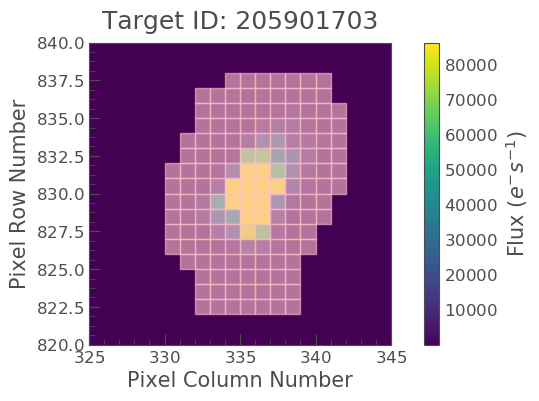

In [10]:
k2_tpf.plot(aperture_mask=k2_tpf.pipeline_mask)

Lightkurve provides 3 ways to define a custom mask:
* a manually defined boolean array 
* a treshold mask 
* interactively

The mask made by create_threshold_mask consists of pixels whose median flux is 3x larger than the standard deviation of the overall median.  The default ratio is 3, but you can specify other threshold ratios if you like.

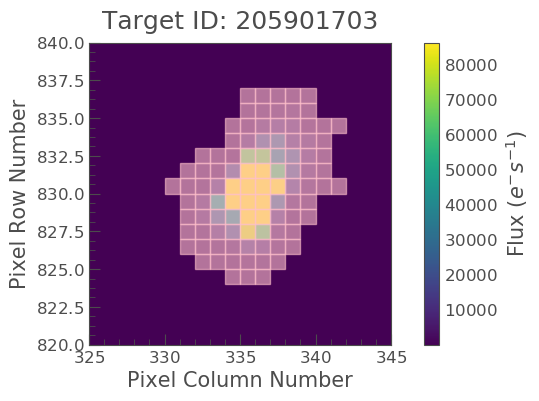

In [11]:
threshold_mask = k2_tpf.create_threshold_mask()

k2_tpf.plot(aperture_mask = threshold_mask)

Lightkurve's interact functionality makes it easy to check out any image that corresponds to a time step and investigate alternate apertures. 

By pointing and clicking on the image, you can define your own aperture mask.  You can select and drag to create rectangular apertures.  Holding down the shift key while you click will let you add/subtract individual pixels.  The displayed lightcurve is recalculated according to the selected pixels.

In [12]:
k2_tpf.interact()


If you create a lightcurve interactively that you want to keep, just use the *Save Lightcurve* button to save the lightcurve in a fits file.

Your new lightcurve can be read in as a LightCurve object, just like you would for any of the pipeline products.

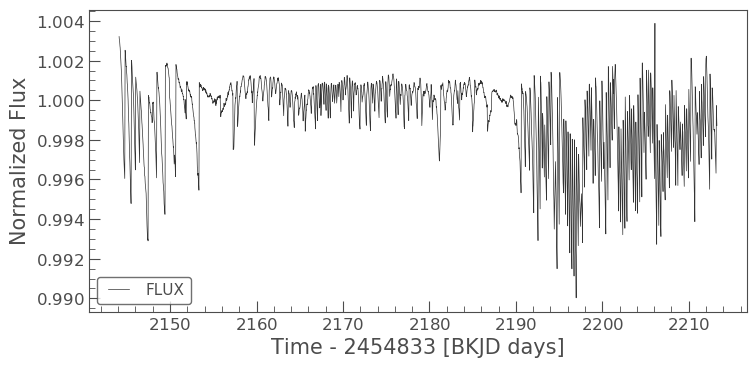

In [13]:
interact_lcf = lk.open("ktwo205901703-c03_lpd-targ-custom-lc.fits")

interact_lcf.plot()

And your custom aperture mask is there in the HDU waiting for you!

In [14]:
custom_mask = interact_lcf.hdu['APERTURE'].data > 1

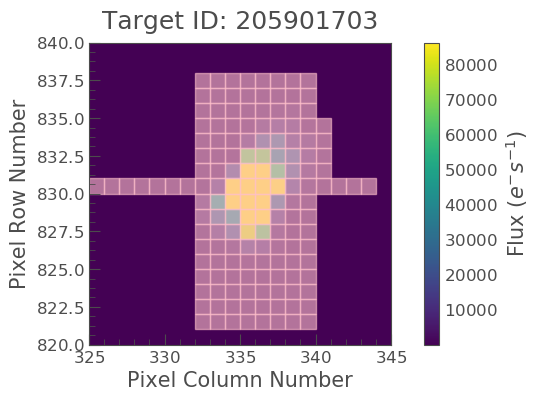

In [15]:
k2_tpf.plot(aperture_mask=custom_mask)

## 4. Creating a Lightcurve

Lightkurve can generate a lightcurve from a target pixel file via aperture photometry or prf photometry.   Today, we're going to stick with aperture photometry.  (More info about using lightkurve for prf photometry is available at https://docs.lightkurve.org/.)

Let's do one last check before moving onto creating a lightcurve though -- let's check that there's nothing funky going on in the default background...

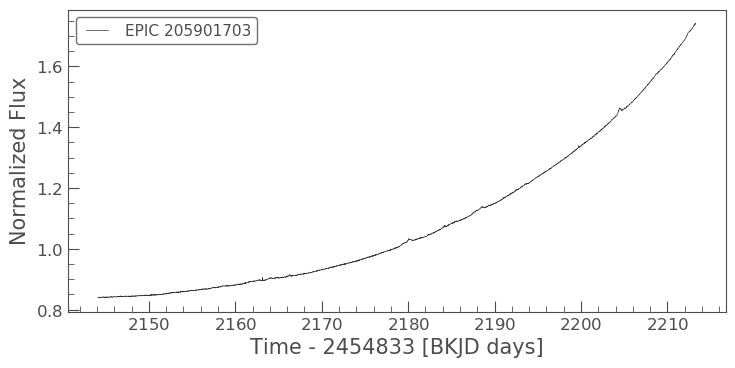

In [16]:
temp = k2_tpf.get_bkg_lightcurve()
temp.plot()

Looks like the pipeline did a pretty good job identifying background pixels -- so let's move on.

After section #3, we have several different apertures we can try out...  So let's try them all and compare!

First off, let's use the pipeline mask.

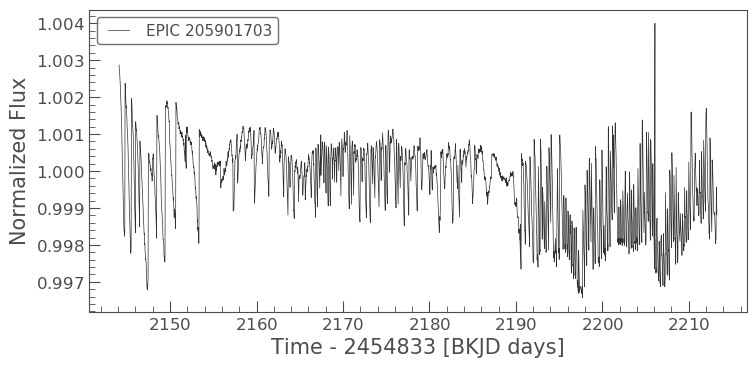

In [17]:
k2_lcf = k2_tpf.to_lightcurve()

k2_lcf.plot()

And now the threshold mask...

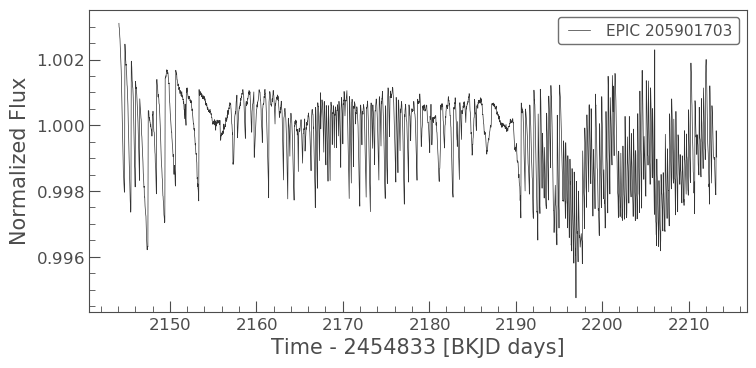

In [18]:
threshold_lcf = k2_tpf.to_lightcurve(aperture_mask=threshold_mask)

threshold_lcf.plot()

And finally, a lightcurve from the custom mask...

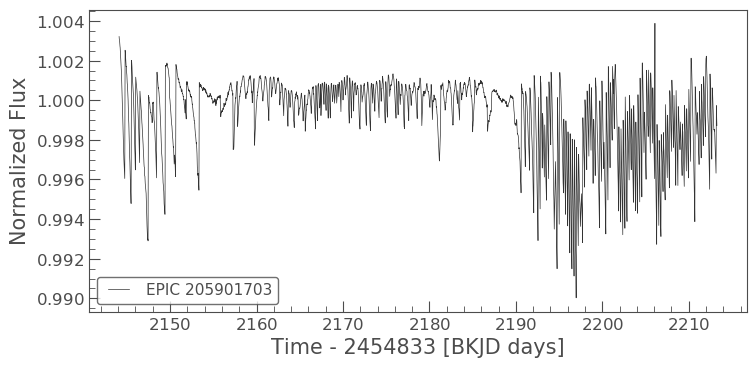

In [19]:
custom_lcf = k2_tpf.to_lightcurve(aperture_mask = custom_mask)

custom_lcf.plot()

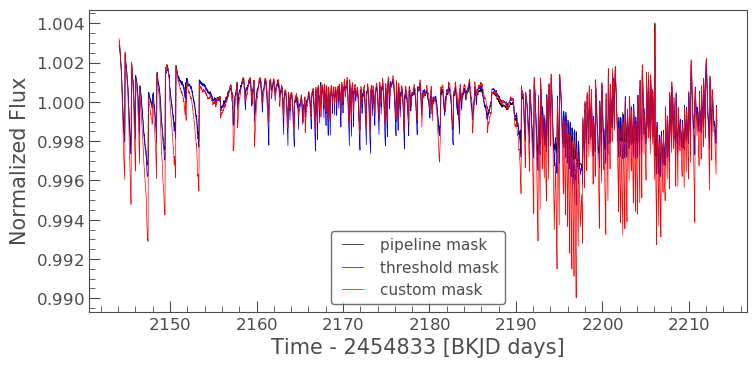

In [20]:
ax = k2_lcf.plot(color="k",linestyle="-",label='pipeline mask')  #black
ax = threshold_lcf.plot(ax=ax,color="b",linestyle='-',label='threshold mask')  #blue
custom_lcf.plot(ax=ax,color="r",linestyle="-",label='custom mask')  #red

## 5. Correcting lightcurves

Lightkurve makes it easy to do simple corrections to your lightcurve.  

* lcf.remove_nans()
* lcf.remove_outliers()
* lcf.normalize()
* lcf.flatten()
* lcf.bin()

*Not sure which of these to demonstrate...  Probably depends a bit on the target used in the tutorial...*

## 6. Removing systematics

There are several available approaches for removing systematics.  The pipeline lightcurve files include photometry corrected by the Presearch Data Conditioning algorithm.  Let's start by looking at that lightcurve...

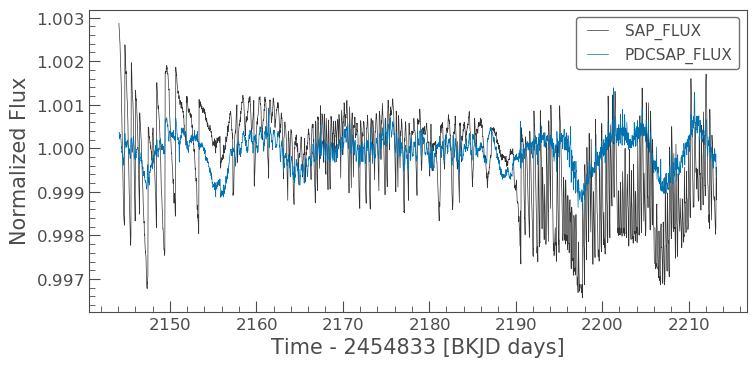

In [21]:
k2_pipeline_lcf = lk.search_lightcurvefile(mytarget, mission="K2").download()

k2_pipeline_lcf.plot()

Lightkurve provides 3 ways to perform your own systematics correction.  
* Cotrending basis vector correction 
* self-flat fielding
* pixel level decorrelation

We'll step through the first two methods here.  (If you want more info about the pixel level decorrelation method, come talk to us later!)

The cotrending basis vector correction utilizes a method similar to -- but not identical to the pipeline's PDC.  (A good place to learn more about CBV's is Demystifying Kepler Data at https://arxiv.org/pdf/1207.3093.pdf).  Lightkurve's KeplerCBVCorrector can be applied to lightcurves created by custom masks.  In addition, you can also specify which of the CBVs to use in your correction.

*(Note to myself...  need to understand the difference here...  But sure it's a bit complicated since the pipeline's PDC can be generated by different methods!)*

Let's first plot up the CBVs to see what they look like...

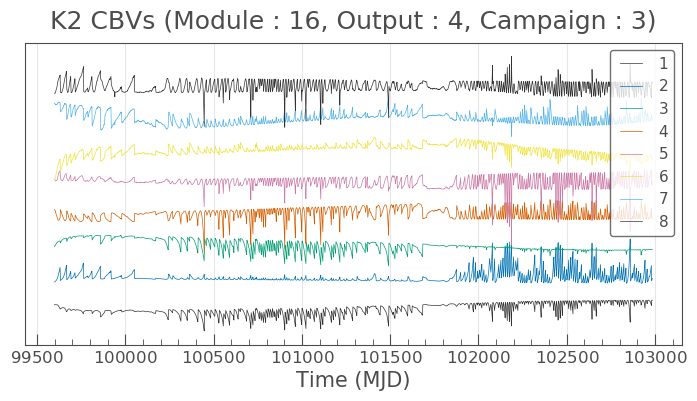

In [22]:
lk.KeplerCBVCorrector(threshold_lcf).plot_cbvs([1,2,3,4,5,6,7,8])

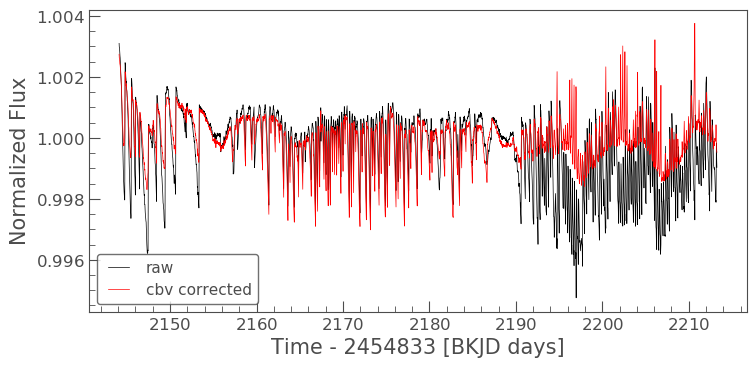

In [23]:
threshold_lcf_corr = lk.KeplerCBVCorrector(threshold_lcf).correct()

ax=threshold_lcf.plot(color="k", label='raw',linestyle="-")
threshold_lcf_corr.plot(ax=ax, label='cbv corrected', color="r", linestyle="-")

Let's also have a go at a self-flat fielding correction.  The lightkurve implementation of SFF is heavily based on Vanderburg & Jonson 2014 (https://arxiv.org/pdf/1408.3853.pdf).  There are several tuning parameters for the lightkurve sff correction.  

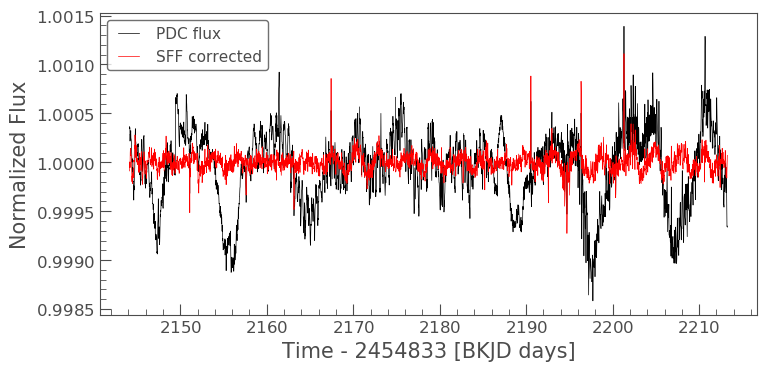

In [24]:
pipeline_pdc_lc = k2_pipeline_lcf.PDCSAP_FLUX

corr_lc = pipeline_pdc_lc.to_corrector("sff").correct(windows=20)

ax = pipeline_pdc_lc.plot(color='k',label="PDC flux")
corr_lc.plot(ax=ax,color="r",label="SFF corrected")

## 7. Exporting Lightcurves

Lightkurve includes functions for converting lightcurves to other formats (pandas, astropy table) and to write them to disk as either csv or fits files.

First let's convert our corrected lightcurve to pandas...

In [25]:
panda_lc = corr_lc.to_pandas()


To an astropy table...

In [26]:
table_lc = corr_lc.to_table()

Finally let's write it out in two different formats...

In [29]:
corr_lc.to_fits("my_lightcurve.fits", overwrite="TRUE")

corr_lc.to_csv("my_lightcurve.csv")

## Next Steps

Three easy ways to learn more about lightkurve

1.  Oliver Hall's tutorial on astereoseismology with lightkuve (up next!)
2.  Visit lightkurve.org
3.  Talk to Christina Hedges, Nicholas Saunders, or myself.
